In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Preparing the dataset

In [3]:
from tensorflow.keras.datasets import mnist

train_ds, test_ds = mnist.load_data()

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)

In [5]:
def process(img, label):
    img = tf.expand_dims(img, axis=2)
    return img, label

In [6]:
train_ds = train_ds.take(5000).map(process).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.take(800).map(process).batch(32).prefetch(tf.data.AUTOTUNE)


# 2. Building the model

In [7]:
from tensorflow.keras import Sequential

data_augumentation = Sequential([
    tf.keras.layers.RandomRotation(0.2),               # 20% rotation
    tf.keras.layers.RandomZoom(0.1),                   # 10% zoom in/out
    tf.keras.layers.RandomTranslation(0.1, 0.1),       # 10% height and width shift
    tf.keras.layers.RandomContrast(0.1),               # Adjust contrast slightly
])

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Rescaling(1./255),

    data_augumentation,

    tf.keras.layers.Conv2D(filters=4, kernel_size=7),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),


    tf.keras.layers.Dense(10),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('softmax'),
])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 22, 22, 4)         200       
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 4)        16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 22, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 16)        1616      
                                                      

# 3. Preparing for training

In [9]:
import datetime as dt

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

log_dir = './logs/' + dt.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
callbacks = [tensorboard_cb, earlystopping_cb]

In [10]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(train_ds, validation_data=test_ds, callbacks=callbacks, epochs=6)

Epoch 1/6
157/157 [==============================] - 162s 914ms/step - loss: 1.6141 - accuracy: 0.4268 - val_loss: 3.8143 - val_accuracy: 0.4812
Epoch 2/6
157/157 [==============================] - 131s 836ms/step - loss: 1.0496 - accuracy: 0.6478 - val_loss: 1.4694 - val_accuracy: 0.6675
Epoch 3/6
157/157 [==============================] - 53s 334ms/step - loss: 0.7441 - accuracy: 0.7650 - val_loss: 0.4792 - val_accuracy: 0.8325
Epoch 4/6
157/157 [==============================] - 51s 323ms/step - loss: 0.6326 - accuracy: 0.7992 - val_loss: 0.5168 - val_accuracy: 0.8450
Epoch 5/6
157/157 [==============================] - 51s 326ms/step - loss: 0.4920 - accuracy: 0.8498 - val_loss: 0.3413 - val_accuracy: 0.8900
Epoch 6/6
157/157 [==============================] - 71s 451ms/step - loss: 0.4361 - accuracy: 0.8654 - val_loss: 0.2587 - val_accuracy: 0.9150


# 4. Inference

In [36]:
import matplotlib.pyplot as plt

X, y = next(test_ds.as_numpy_iterator())

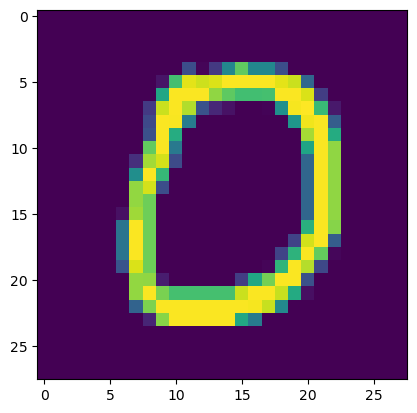

In [39]:
img = X[10]
plt.imshow(img)

In [40]:
pred = model.predict(img[np.newaxis, ...])
print(f"The model predicted: {pred.argmax()}")

1/1 [==============================] - 0s 47ms/step
The model predicted: 0


# 5. Saving the model

In [ ]:
model.save('./best_model')

INFO:tensorflow:Assets written to: ./best_model\assets


INFO:tensorflow:Assets written to: ./best_model\assets
